# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved.
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server.

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
from itertools import combinations
import numpy as np
import scipy.io as sio
import torch

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Analysis of the Dictionary

In [2]:
#storing the training dictionary words in a list
full_dictionary_location = "words_250000_train.txt"
def build_dictionary(dictionary_file_location):
    text_file = open(dictionary_file_location,"r")
    full_dictionary = text_file.read().splitlines()
    text_file.close()
    return full_dictionary
full_dictionary = build_dictionary(full_dictionary_location)
print("Total number of words in the given training dictionary is",len(full_dictionary))

Total number of words in the given training dictionary is 227300


In [3]:
#printing (length of word, number of words)
length_dict = collections.defaultdict(int)
for word in full_dictionary:
    length_dict[len(word)]+=1
sorted(length_dict.items(), key=lambda x:x[0])

[(1, 17),
 (2, 264),
 (3, 2201),
 (4, 5287),
 (5, 11274),
 (6, 19541),
 (7, 25948),
 (8, 30452),
 (9, 30906),
 (10, 26953),
 (11, 22786),
 (12, 18178),
 (13, 12956),
 (14, 8710),
 (15, 5211),
 (16, 3143),
 (17, 1775),
 (18, 859),
 (19, 441),
 (20, 225),
 (21, 98),
 (22, 44),
 (23, 14),
 (24, 9),
 (25, 3),
 (27, 2),
 (28, 1),
 (29, 2)]

In [4]:
#printing (number of unique letters, number of words)
no_unique_letters = collections.defaultdict(int)
for word in full_dictionary:
    no_unique_letters[len(set(word))]+=1
sorted(no_unique_letters.items(), key=lambda x:x[0])

[(1, 41),
 (2, 615),
 (3, 3922),
 (4, 10957),
 (5, 23662),
 (6, 36843),
 (7, 43960),
 (8, 41767),
 (9, 31969),
 (10, 19691),
 (11, 9366),
 (12, 3399),
 (13, 875),
 (14, 199),
 (15, 30),
 (16, 4)]

In [5]:
#printing (alphabet,number of times it occurs in the dictionary)
full_dictionary_common_letter_sorted = collections.Counter("".join(full_dictionary)).most_common()
print(full_dictionary_common_letter_sorted)

[('e', 233745), ('i', 184746), ('a', 179837), ('n', 152259), ('o', 150052), ('r', 149228), ('s', 148462), ('t', 137277), ('l', 122431), ('c', 89367), ('u', 77304), ('d', 74856), ('p', 65785), ('m', 62191), ('h', 58051), ('g', 51850), ('y', 40985), ('b', 39840), ('f', 26431), ('v', 21057), ('k', 18685), ('w', 17732), ('z', 8749), ('x', 6050), ('q', 3986), ('j', 3790)]


In [6]:
#printing (alphabet,number of words that contain it)
new_dict = {}
count  = 0
for k,l in full_dictionary_common_letter_sorted:
    new_dict[k] = 0
for i in range(len(full_dictionary)):
    count+=1
    s = set()
    for j in range(len(full_dictionary[i])):
        if full_dictionary[i][j] not in s:
            s.add(full_dictionary[i][j])
            new_dict[full_dictionary[i][j]] += 1
sorted(new_dict.items(), key=lambda x:x[1],reverse = True)

[('e', 154827),
 ('i', 134627),
 ('a', 133659),
 ('r', 120548),
 ('n', 114976),
 ('o', 111416),
 ('s', 110214),
 ('t', 108416),
 ('l', 97083),
 ('c', 75526),
 ('u', 67623),
 ('d', 65225),
 ('p', 57125),
 ('m', 55506),
 ('h', 52006),
 ('g', 46878),
 ('y', 38705),
 ('b', 36789),
 ('f', 23530),
 ('v', 20203),
 ('k', 17594),
 ('w', 16813),
 ('z', 8273),
 ('x', 6013),
 ('q', 3903),
 ('j', 3731)]

In [7]:
fixed_letters = ['e','i','a']
fixed_letters_set = set(fixed_letters)
exists_dict = collections.defaultdict(int)
for word in full_dictionary:
    s = set(word)
    count = 0
    for letter in fixed_letters:
        if letter in s:
            count +=1
    exists_dict[count]+=1
sorted(exists_dict.items(), key=lambda x:x[0])

[(0, 8788), (1, 61692), (2, 109039), (3, 47781)]

21% of the words contain all three letters

48% of the words contain two of the three letters

27% of the words contain one of the three letters

4% of the words contain none of the three letters

# Masked dictionary generation

In [8]:
#creating dictionary to map alphabets to numbers and viceversa
char_to_int = {}
int_to_char = {}
for i in range(1,27):
    char_to_int[chr(i+ord('a')-1)] = i
    int_to_char[i] = chr(i+ord('a')-1)
char_to_int['_'] = 27
int_to_char[27] = '_'

In [9]:
print(char_to_int)
print(int_to_char)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '_': 27}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '_'}


In [10]:
#For each word in the training dictionary, I generated their masked words by randomly replacing all letters but the letters in the fixed set with underscore.
def generate_masked_states(word):
    remaining_letters = list(set(word)-fixed_letters_set)
    masked_states = []
    length = len(remaining_letters)
    for k in range(2):
        for i in range(1,length+1):
            random_letters = random.sample(remaining_letters, i)
            new_masked_word = word
            for letter in random_letters:
                new_masked_word = new_masked_word.replace(letter, "_")
                masked_states.append(new_masked_word)
    return list(set(masked_states))

In [11]:
masked_dictionary = []
new_dictionary = []
for word in full_dictionary:
    masked_states = generate_masked_states(word)
    for i in range(len(masked_states)):
        new_dictionary.append(word)
        masked_dictionary.append(masked_states[i])

In [12]:
#f = open("masked_dictionary.txt", "x")
#g = open("new_dictionary.txt", "x")
print(len(new_dictionary))
print(len(masked_dictionary))

6210087
6210087


# Encoding the input and output

In [13]:
#Input encoding : I used numerical representation to encode the underscore and alphabets. I mapped the alphabets ‘a-z’ to 1-26 and ‘_’ to 27. I used this mapping to convert the masked word into a numerical sequence. Then I padded zeros before the encoded sequence to get a sequence of fixed length 30.
#Output Encoding: To encode the target word, I used a 26 dimensional vector where the ith element corresponds to the ith alphabet and it is equal to 1 if the alphabet is present in the target word, otherwise it is zero.
def encode(masked_word,word):
    input = [0]*len(word)
    output = [0]*26
    s = set(word) - set(masked_word)
    for i in range(len(word)-1,-1,-1):
        input[i] = char_to_int[masked_word[i]]
        output[char_to_int[word[i]]-1] = 1
    input = [0]*(30-len(word))+input
    return input,output

In [14]:
def encode_input(masked_word):
    input = [0]*len(masked_word)
    for i in range(len(masked_word)-1,-1,-1):
        input[i] = char_to_int[masked_word[i]]
    input = [0]*(30-len(masked_word))+input
    return input

In [15]:
input,output = encode('__a__e_','oranges')
print(input,output)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 27, 1, 27, 27, 5, 27] [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [16]:
all_inputs = []
all_outputs = []
for i in range(len(new_dictionary)):
    input,output = encode(masked_dictionary[i],new_dictionary[i])
    all_inputs.append(input)
    all_outputs.append(output)
all_inputs = np.array(all_inputs)
all_outputs = np.array(all_outputs)

In [ ]:
#sio.savemat('inputs.mat',{'input_vectors':all_inputs})
#sio.savemat('outputs.mat',{'output_vectors':all_outputs})
'''
print(new_dictionary[10:20])
print(masked_dictionary[10:20])
print(all_inputs[10:20])
print(all_outputs[10:20])
'''

'\nprint(new_dictionary[10:20])\nprint(masked_dictionary[10:20])\nprint(all_inputs[10:20])\nprint(all_outputs[10:20])\n'

In [17]:
print(all_inputs.shape)
print(all_outputs.shape)

(6210087, 30)
(6210087, 26)


# Training the LSTM

In [18]:
class New_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        #self.all_inputs = sio.loadmat('inputs.mat')['input_vectors']
        #self.all_outputs = sio.loadmat('outputs.mat')['output_vectors']
        self.all_inp = all_inputs
        self.all_out = all_outputs

    def __len__(self):
        return len(self.all_inp)

    def __getitem__(self, index):
        inp = self.all_inp[index]
        out = self.all_out[index]
        return torch.from_numpy(inp),torch.from_numpy(out)

# Model Definition

In [19]:
import torch
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMClassifier, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim,max_norm=1)
        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True,dropout=0.1)
        # Fully connected layer
        self.fc1 = nn.Linear(2*hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        #self.fc3 = nn.Linear(hidden_dim//2, output_dim)


    def forward(self, x):
        x = self.embedding(x)
        # Forward propagate LSTM
        out, _ = self.lstm(x)
        # Take the output of the last time step
        out = out[:, -1, :]
        # Fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        #out = self.fc3(out)
        return out
'''
def main():
    # Check model behaves as desired:
    model = BiLSTMClassifier(vocab_size = 28,embedding_dim = 32,hidden_dim = 64,output_dim = 26)
    x = torch.tensor(all_inputs[10:20])
    out = model(x)

if __name__ == '__main__':
    main()
'''

"\ndef main():\n    # Check model behaves as desired:\n    model = BiLSTMClassifier(vocab_size = 28,embedding_dim = 32,hidden_dim = 64,output_dim = 26)\n    x = torch.tensor(all_inputs[10:20])\n    out = model(x)\n\nif __name__ == '__main__':\n    main()\n"

**Training**

Device: cuda
EPOCH 1 ...
Training loss was 21.892801431577208
Validation loss was 21.58233194548752
EPOCH 1 finished...
EPOCH 2 ...
Training loss was 21.540399132554295
Validation loss was 21.462211277857644
EPOCH 2 finished...
EPOCH 3 ...
Training loss was 21.462850278087213
Validation loss was 21.41849084005127
EPOCH 3 finished...
EPOCH 4 ...
Training loss was 21.422741632130084
Validation loss was 21.388683127236465
EPOCH 4 finished...
EPOCH 5 ...
Training loss was 21.397462074989985
Validation loss was 21.35839775047707
EPOCH 5 finished...
EPOCH 6 ...
Training loss was 21.37994499782487
Validation loss was 21.33763939870162
EPOCH 6 finished...
EPOCH 7 ...
Training loss was 21.365578379697507
Validation loss was 21.33205991998771
EPOCH 7 finished...
EPOCH 8 ...
Training loss was 21.354309416540875
Validation loss was 21.316291737922576
EPOCH 8 finished...
EPOCH 9 ...
Training loss was 21.34547404138699
Validation loss was 21.309327202311106
EPOCH 9 finished...
EPOCH 10 ...
Training 

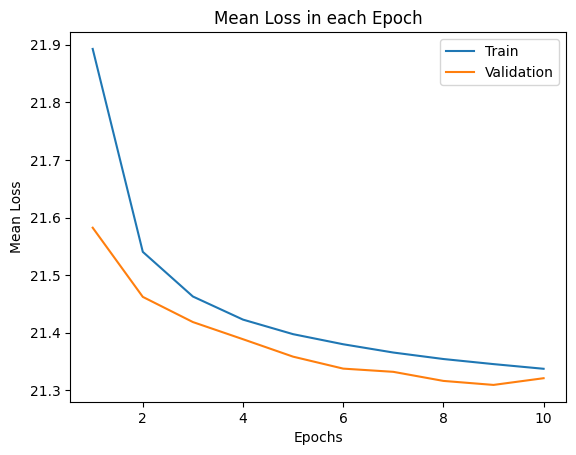

In [24]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import matplotlib.pyplot as plt

# HYPERPARAMS:
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
VAL_BATCH_SIZE = 128
WEIGHT_DECAY = 0.0001
EPOCHS = 10

def main():
    # checkpoint to save the model later:
    global checkpoint
    # print device:
    print(f'Device: {DEVICE}')
    # set the model, optimizer and custom loss:
    model = BiLSTMClassifier(vocab_size = 28,embedding_dim = 64,hidden_dim = 128,output_dim = 26).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
    loss_fn = nn.CrossEntropyLoss()

    # Take full Dataset, divide into train and validation:
    full_dataset = New_Dataset()
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Use dataloader for the datasets separately:
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, drop_last=True)

    # initialize mean training and validation loss:
    training_loss = np.zeros((1, EPOCHS))
    valid_loss = np.zeros((1, EPOCHS))

    for epoch in range(EPOCHS):
        print(f"EPOCH {epoch+1} ...")
        train_loss = []
        val_loss = []
        torch.autograd.set_detect_anomaly(True)
        # TRAINING LOOP:
        model.train()
        for batch_idx, (x,y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE, dtype=torch.float)
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out,y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Print mean loss and return:
        print(f"Training loss was {sum(train_loss)/len(train_loss)}")
        training_loss[0,epoch] = sum(train_loss)/len(train_loss)
        model.eval()
        # VALIDATION LOOP:
        with torch.no_grad():
            for batch_idx, (a,b) in enumerate(val_loader):
                a, b = a.to(DEVICE), b.to(DEVICE, dtype=torch.float)
                output = model(a)
                loss = loss_fn(output,b)
                val_loss.append(loss.item())
        print(f"Validation loss was {sum(val_loss)/len(val_loss)}")
        valid_loss[0,epoch] = sum(val_loss)/len(val_loss)
        print(f"EPOCH {epoch+1} finished...")

    # Saving the model
    torch.save(model.state_dict(), "temp8.pt")
    #Plotting the loss vs epoch graph
    x_axis = np.arange(1,EPOCHS+1)
    plt.figure()
    plt.plot(x_axis, training_loss[0,:], label = 'Train')
    plt.plot(x_axis, valid_loss[0, :], label='Validation')
    plt.title("Mean Loss in each Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Mean Loss')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()

In [25]:
model =  BiLSTMClassifier(vocab_size = 28,embedding_dim = 64,hidden_dim = 128,output_dim = 26).to(DEVICE)
model.load_state_dict(torch.load("temp8.pt"))
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

631962


In [20]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []

        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()

        self.current_dictionary = []

    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def guess(self, word): # word input example: "_ p p _ e "
        # clean the word so that we strip away the space characters
        clean_word = word[::2]

        # find length of passed word
        len_word = len(clean_word)

        if len_word>30:
            sorted_letter_count = sorted(new_dict.items(), key=lambda x:x[1],reverse = True)
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    guess_letter = letter
                    return guess_letter

        guess_letter = '!'

        if len(self.guessed_letters) == 0:
            guess_letter = 'e'
        elif len(self.guessed_letters) == 1:
            guess_letter = 'i'
        elif len(self.guessed_letters) == 2:
            guess_letter = 'a'
        else:
            model =  BiLSTMClassifier(vocab_size = 28,embedding_dim = 64,hidden_dim = 128,output_dim = 26) #Modify parameters
            model.load_state_dict(torch.load("temp8.pt",map_location=torch.device('cpu'))) #Modify the filename
            inp_tensor = torch.tensor(encode_input(clean_word)).resize_(1,30)
            model.eval()
            with torch.no_grad():
                softmax = nn.Softmax()
                out_tensor = softmax(model(inp_tensor))
            indices = torch.argsort(out_tensor[0],descending = True).numpy()
            indices = indices+1
            likely_letters = []
            for i in range(26):
                likely_letters.append(int_to_char[indices[i]])
            for letter in likely_letters:
                if letter not in self.guessed_letters:
                    guess_letter = letter
                    break

        return guess_letter

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################

    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary

    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary

        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)

                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))

                try:
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e

                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"

    def my_status(self):
        return self.request("/my_status", {})

    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result

class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object.
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [21]:
api = HangmanAPI(access_token="3348ee1697dda3b78774b2a6de1091", timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [29]:
no_practice_runs = 1000
initial_successes = api.my_status()[3]

In [30]:
for i in range(no_practice_runs):
    print('Playing ', i, ' th game')
    api.start_game(practice=1,verbose=True)
    time.sleep(0.5)

[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

Playing  0  th game
Successfully start a new game! Game ID: 3703d73e95a7. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '3703d73e95a7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ _ e _ _ '}
Guessing letter: i
Sever response: {'game_id': '3703d73e95a7', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ i _ i _ _ _ _ e _ _ '}
Guessing letter: a
Sever response: {'game_id': '3703d73e95a7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i _ i _ _ _ _ e _ _ '}
Guessing letter: n


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
Guessing letter: s
Sever response: {'game_id': '2582b75acb08', 'status': 'ongoing', 'tries_remains': 4, 'word': 'r _ _ _ e _ s _ i _ _ s _ i _ '}
Guessing letter: n
Sever response: {'game_id': '2582b75acb08', 'status': 'ongoing', 'tries_remains': 4, 'word': 'r _ _ _ e _ s _ i _ _ s _ i n '}
Guessing letter: t
Sever response: {'game_id': '2582b75acb08', 'status': 'ongoing', 'tries_remains': 4, 'word': 'r _ _ _ e _ s t i _ t s _ i n '}
Guessing letter: u
Sever response: {'game_id': '2582b75acb08', 'status': 'ongoing', 'tries_remains': 4, 'word': 'r u _ _ e _ s t i _ t s _ i n '}
Guessing letter: b
Sever response: {'game_id': '2582b75acb08', 'status': 'ongoing', 'tries_remains': 3, 'word': 'r u _ _ e _ s t i _ t s _ i n '}
Guessing letter: l
Sever response: {'game_id': '2582b75acb08', 'status': 'ongoing', 'tries_remains': 3, 'word': 'r u _ _ e l s t i l t s _ i n '}
Guessing letter: m
Sever response: {'game_id': '2582b75acb08', 'status': 

In [32]:
final_successes = api.my_status()[3]
print("Practice success rate :",(final_successes - initial_successes)/no_practice_runs)

Practice success rate : 0.525


## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [24]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)

    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [25]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.569
